In [1]:
import os
import sys
import re
from datetime import datetime, timedelta
import pickle as pkl

import sparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from argparse import ArgumentParser

parser = ArgumentParser()
parser.add_argument('--datadir', type=str, default='../../data/traffic')
parser.add_argument('--cluster_ratio', type=float, default=0.1, help='cluster N nodes to [N*r] clusters')

args = parser.parse_args([
    '--cluster_ratio', '0'
])
print(args)

Namespace(cluster_ratio=0.0, datadir='../../data/traffic')


In [5]:
raw_data = pd.read_csv(os.path.join(args.datadir, 'traffic.txt'), delimiter=',', header=None)
raw_data
# raw_data.index.freq = raw_data.index.inferred_freq
# data = raw_data.values[:, :, np.newaxis]

,0,1,2,3,4,5,6,7,8,9,...,852,853,854,855,856,857,858,859,860,861
0,0.0048,0.0146,0.0289,0.0142,0.0064,0.0232,0.0162,0.0242,0.0341,0.0375,...,0.0051,0.0051,0.0074,0.0079,0.0051,0.0051,0.0339,0.0051,0.0100,0.0121
1,0.0072,0.0148,0.0350,0.0174,0.0084,0.0240,0.0201,0.0338,0.0434,0.0381,...,0.0036,0.0036,0.0107,0.0058,0.0036,0.0036,0.0348,0.0036,0.0087,0.0136
2,0.0040,0.0101,0.0267,0.0124,0.0049,0.0170,0.0127,0.0255,0.0332,0.0309,...,0.0030,0.0030,0.0043,0.0050,0.0030,0.0030,0.0327,0.0030,0.0061,0.0107
3,0.0039,0.0060,0.0218,0.0090,0.0029,0.0118,0.0088,0.0163,0.0211,0.0199,...,0.0033,0.0033,0.0019,0.0052,0.0033,0.0033,0.0292,0.0033,0.0040,0.0071
4,0.0042,0.0055,0.0191,0.0082,0.0024,0.0095,0.0064,0.0087,0.0144,0.0226,...,0.0049,0.0049,0.0011,0.0071,0.0049,0.0049,0.0264,0.0049,0.0040,0.0039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17539,0.0342,0.0332,0.1378,0.0559,0.0165,0.0386,0.0457,0.0687,0.0716,0.0518,...,0.0139,0.0179,0.0278,0.0280,0.0227,0.0375,0.0142,0.0201,0.0341,0.0429
17540,0.0285,0.0253,0.0542,0.0485,0.0131,0.0331,0.0372,0.0569,0.0669,0.0409,...,0.0116,0.0155,0.0201,0.0267,0.0207,0.0320,0.0122,0.0163,0.0306,0.0363
17541,0.0276,0.0257,0.0551,0.0474,0.0121,0.0326,0.0381,0.0566,0.0675,0.0386,...,0.0109,0.0142,0.0208,0.0252,0.0189,0.0287,0.0123,0.0152,0.0292,0.0325
17542,0.0232,0.0229,0.0496,0.0435,0.0119,0.0297,0.0361,0.0517,0.0598,0.0360,...,0.0092,0.0124,0.0219,0.0215,0.0169,0.0258,0.0096,0.0130,0.0252,0.0279


In [4]:
raw_data.head()

sensor_id,400001,400017,400030,400040,400045,400052,400057,400059,400065,400069,...,409525,409526,409528,409529,413026,413845,413877,413878,414284,414694
2017-01-01 00:00:00,71.4,67.8,70.5,67.4,68.8,66.6,66.8,68.0,66.8,69.0,...,68.8,67.9,68.8,68.0,69.2,68.9,70.4,68.8,71.1,68.0
2017-01-01 00:05:00,71.6,67.5,70.6,67.5,68.7,66.6,66.8,67.8,66.5,68.2,...,68.4,67.3,68.4,67.6,70.4,68.8,70.1,68.4,70.8,67.4
2017-01-01 00:10:00,71.6,67.6,70.2,67.4,68.7,66.1,66.8,67.8,66.2,67.8,...,68.4,67.4,68.4,67.5,70.2,68.3,69.8,68.4,70.5,67.9
2017-01-01 00:15:00,71.1,67.5,70.3,68.0,68.5,66.7,66.6,67.7,65.9,67.8,...,68.5,67.5,68.5,67.5,70.4,68.7,70.2,68.4,70.8,67.6
2017-01-01 00:20:00,71.7,67.8,70.2,68.1,68.4,66.9,66.1,67.7,66.1,67.8,...,68.5,67.7,68.5,67.4,69.6,69.1,70.0,68.4,71.0,67.9


In [5]:
def load_sensor_latlong(dataset, datadir):
    if dataset == 'METR-LA':
        loc = pd.read_csv(os.path.join(datadir, 'sensor_graph', 'graph_sensor_locations.csv'), header=0)
        latlong = loc[['latitude', 'longitude']].values
    elif dataset == 'PEMS-BAY':
        loc = pd.read_csv(os.path.join(datadir, 'sensor_graph', 'graph_sensor_locations_bay.csv'), header=None)
        latlong = loc[[1, 2]].values
    return latlong


locs = load_sensor_latlong(args.dataset, args.datadir)

In [6]:
print(data.shape)
print(locs.shape)

(52116, 325, 1)
(325, 2)


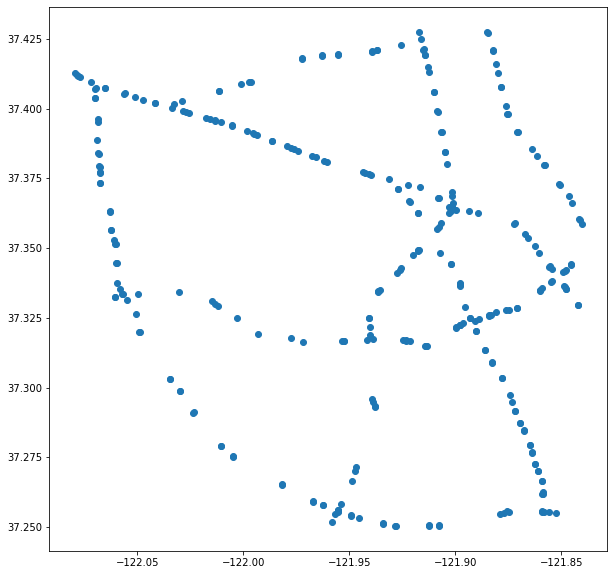

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(locs[:, 1], locs[:, 0])

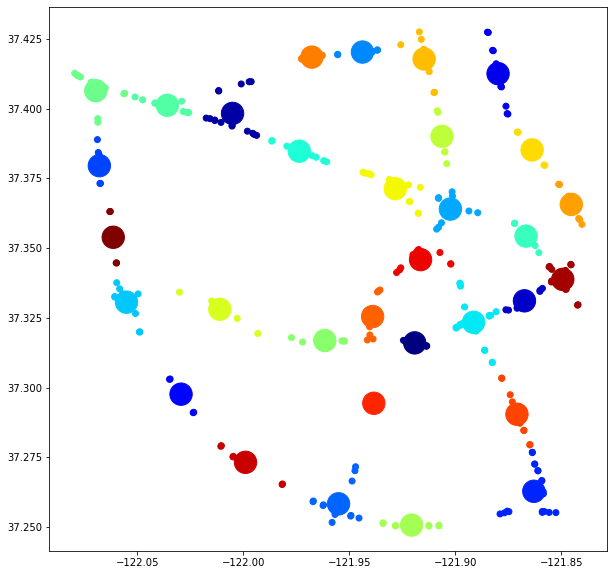

In [8]:
from sklearn.cluster import KMeans

n_clusters = np.round(locs.shape[0] * args.cluster_ratio).astype(int)
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(locs)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(locs[:, 1], locs[:, 0], c=labels, cmap='jet')
ax.scatter(centers[:, 1], centers[:, 0], c=np.arange(n_clusters), s=500, cmap='jet')

In [9]:
locs_all = np.concatenate([locs, centers], axis=0).astype(np.float32)
node_types = np.concatenate([np.zeros(locs.shape[0]), np.ones(centers.shape[0])]).astype(np.int64)

In [10]:
def load_roaddist_graph(dataset, datadir):
    if dataset == 'METR-LA':
        filename = 'adj_mx.pkl'
    elif dataset == 'PEMS-BAY':
        filename = 'adj_mx_bay.pkl'
    with open(os.path.join(datadir, 'sensor_graph', filename), 'rb') as f:
        g = pkl.load(f, encoding='latin1')
    return g[2]


roaddist_graph = load_roaddist_graph(args.dataset, args.datadir)

(4368, 2) (4368,)


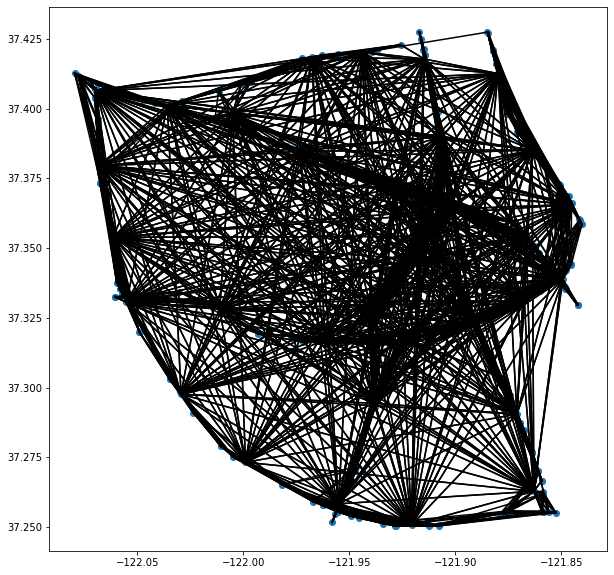

In [11]:
def generate_th_gau_graph(locs_all, node_types, labels, roaddist_graph, vis=False):
    locs_small = locs_all[node_types == 0]
    locs_large = locs_all[node_types == 1]
    
    # specify threshold on small nodes
    noden = locs_small.shape[0]
    assert roaddist_graph.shape[0] == noden
#     dist_m = np.zeros((noden, noden))
#     for ni in range(noden):
#         dist_m[ni, :] = np.linalg.norm(locs_small[ni] - locs_small, axis=1)
#     dist_std = dist_m.std()
#     dist_normed = np.exp(-(dist_m / dist_std)**2)
#     dist_normed[dist_normed <= threshold] = 0
    dist_normed = roaddist_graph
    
    # add large nodes, edges between (small, small) and (small, large) should be kept
    noden_all = locs_all.shape[0]
    dist_normed_all = np.zeros((noden_all, noden_all))
    for ni in range(noden_all):
        for nj in range(noden_all):
            if (ni < noden) and (nj < noden):
                dist_normed_all[ni, nj] = dist_normed[ni, nj]
            elif (ni >= noden) and (nj >= noden):
#                 dist_ni_nj = np.linalg.norm(locs_all[ni] - locs_all[nj])
#                 dist_normed_all[ni, nj] = np.exp(-(dist_ni_nj / dist_std) ** 2)
                dist_normed_all[ni, nj] = 1.0
            else:
                ni_, nj_ = min(ni, nj), max(ni, nj)
                if labels[ni_] + noden == nj_:
#                     dist_ni_nj = np.linalg.norm(locs_all[ni_] - locs_all[nj_])
#                     dist_normed_all[ni_, nj_] = np.exp(-(dist_ni_nj / dist_std) ** 2)
                    dist_normed_all[ni, nj] = 1.0
                    
    exist_edge_ij = np.where(dist_normed_all > 0)
    edges = np.stack(exist_edge_ij, axis=1)
    edges_weights = dist_normed_all[exist_edge_ij]
    print(edges.shape, edges_weights.shape)
    
    if vis:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.scatter(locs_all[:, 1], locs_all[:, 0])
        for i, j in edges:
            if i != j:
                li, lj = locs_all[i], locs_all[j]
                ax.plot([li[1], lj[1]], [li[0], lj[0]], 'k-')
    
    return edges, edges_weights

    
edges, edges_weights = generate_th_gau_graph(locs_all, node_types, labels, roaddist_graph, vis=True)

(52116, 325, 1) 1085.75


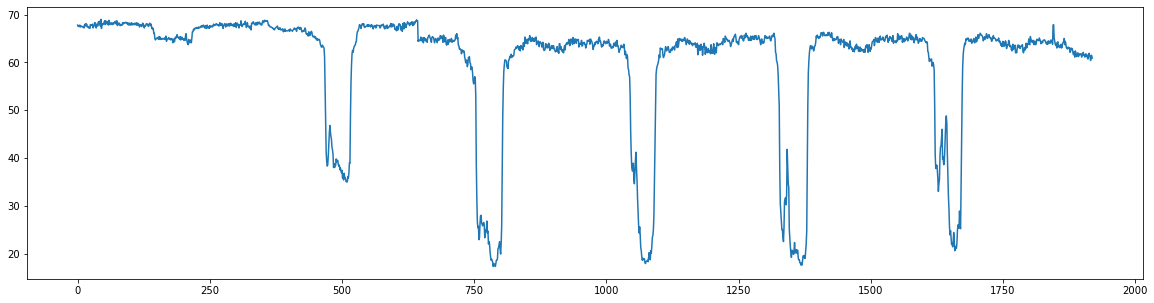

In [12]:
T, N, F = data.shape
data_agg = data.reshape(-1, 1, N, F).mean(axis=1)
print(data_agg.shape, data_agg.shape[0] / 48)

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(data_agg[:48*40, 1, 0])

In [13]:
data_agg_big = []
for ci in range(n_clusters):
    idx = np.where(labels == ci)[0]
#     data_agg_big.append(data_agg[:, idx, :].sum(axis=1))
    data_agg_big.append(data_agg[:, idx, :].mean(axis=1))
data_agg_big = np.stack(data_agg_big, axis=1)
data_agg_all = np.concatenate([data_agg, data_agg_big], axis=1)
print(data_agg_all.shape)

(52116, 357, 1)


In [14]:
volume_valid_region_borough = data_agg_all
edges_valid_region_borough = {
    'edges': edges,
    'edge_types': edges_weights,
    'node_types': node_types
}
temporal_info = {
    'start': raw_data.index[0].to_pydatetime(),
    'delta': (raw_data.index[1] - raw_data.index[0]).to_pytimedelta()
}
print(temporal_info)

save_dir = os.path.join(args.datadir, args.dataset)
sparse.save_npz(os.path.join(save_dir, 'volume_valid_region_borough.npz'), sparse.COO(volume_valid_region_borough))
np.savez(os.path.join(save_dir, 'edges_valid_region_borough.npz'), **edges_valid_region_borough)
np.savez(os.path.join(save_dir, 'temporal_info.npz'), **temporal_info)

{'start': datetime.datetime(2017, 1, 1, 0, 0), 'delta': datetime.timedelta(seconds=300)}
